In [1]:
import pandas as pd
import os
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
sns.set()

In [2]:
os.chdir('C:/Users/Sushant/Documents/newspaper-word-count/Python_DS')
%pwd

'C:\\Users\\Sushant\\Documents\\newspaper-word-count\\Python_DS'

In [3]:
#Convert to time series data
data = pd.read_csv('LYNXdata.csv', header =0, 
                   names =['year', 'trappings'], parse_dates=[0], index_col=0)
data.head()

,trappings
year,
1821-01-01,269
1822-01-01,321
1823-01-01,585
1824-01-01,871
1825-01-01,1475


In [4]:
#Check if the conversion is successful
type(data)

pandas.core.frame.DataFrame

In [5]:
Lynx = data['trappings']
type(Lynx)

pandas.core.series.Series

In [6]:
##Convert to time series by manually creating index
Lynx = pd.Series(data['trappings'].values,
                     index = pd.date_range('31/12/1821' ,
                                           periods = 114,
                                           freq = 'A-DEC'))
type(Lynx)

pandas.core.series.Series

In [7]:
#test for stationarity(Augmented Dickey Fuller Test)--first removes the autocorrelation and conducts test
def stationarity_test(timeseries):
    print ('Dickey Fuller Test:')
    import statsmodels.tsa.stattools as tsa
    test = tsa.adfuller(timeseries, autolag = 'AIC')
    output= pd.Series(test[0:4], 
                      index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    print (output)


In [8]:
stationarity_test(Lynx)

Dickey Fuller Test:
Test Statistic                  -2.996304
p-value                          0.035241
#Lags Used                       7.000000
Number of Observations Used    106.000000
dtype: float64


In [9]:
# Classic ACF and PACF Plots for Autocorrelation
import statsmodels.graphics.tsaplots as tsaplt

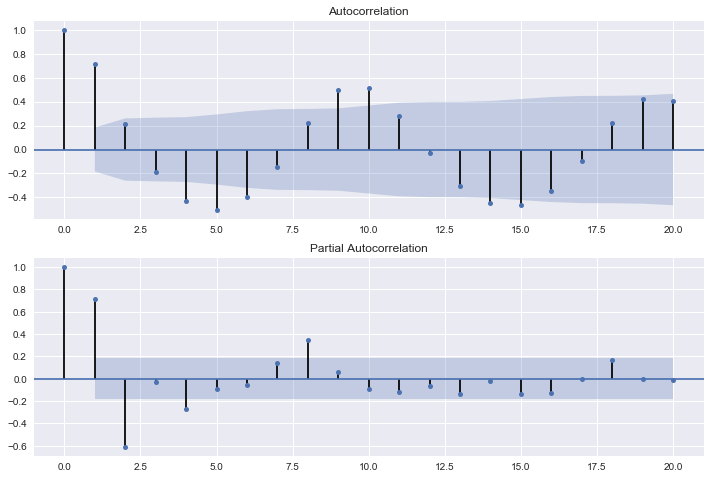

In [10]:
# Autocorrelation and partical autocorrelation plot
# Both plots in same sheet
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = tsaplt.plot_acf(Lynx, lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = tsaplt.plot_pacf(Lynx, lags=20, ax=ax2)

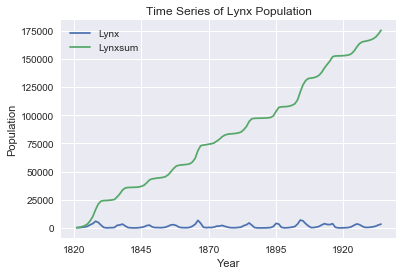

In [11]:
#Plot frequency and cumulative frequency
Lynxsum = np.cumsum(Lynx)

Lynx.plot()
Lynxsum.plot()
plt.title('Time Series of Lynx Population')
plt.xlabel('Year')
plt.ylabel('Population')
plt.legend(['Lynx', 'Lynxsum'])
plt.show()

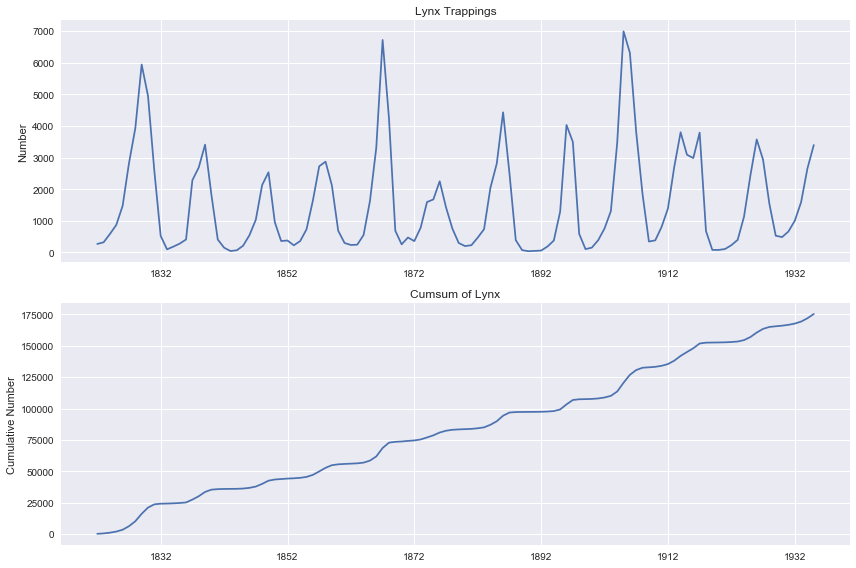

In [12]:
# Getting two visualizations in the same output cell
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(Lynx)
plt.title('Lynx Trappings')
plt.ylabel('Number')

plt.subplot(2,1,2)
plt.plot(Lynxsum)
plt.title('Cumsum of Lynx')
plt.ylabel('Cumulative Number')
plt.tight_layout()

In [13]:
# Simple moving (rolling) calculations
# Note: the rolling methods are applicable only on pandas Series and DataFrame objects
def plot_movingavg(timeseries, window):
    rol_mean = timeseries.rolling(window).mean()
    rol_std = timeseries.rolling(window).std()
    
    fig = plt.figure(figsize = (12, 8))
    og = plt.plot(timeseries, color = "blue", label = "Original")
    mean = plt.plot(rol_mean, color = "red", label = "Rolling Mean")
    std = plt.plot(rol_std, color = "black", label = "Rolling Std")
    plt.legend(loc = "best")
    plt.title("Rolling Mean and Standard Deviation (window = "+str(window)+")")
    plt.show()

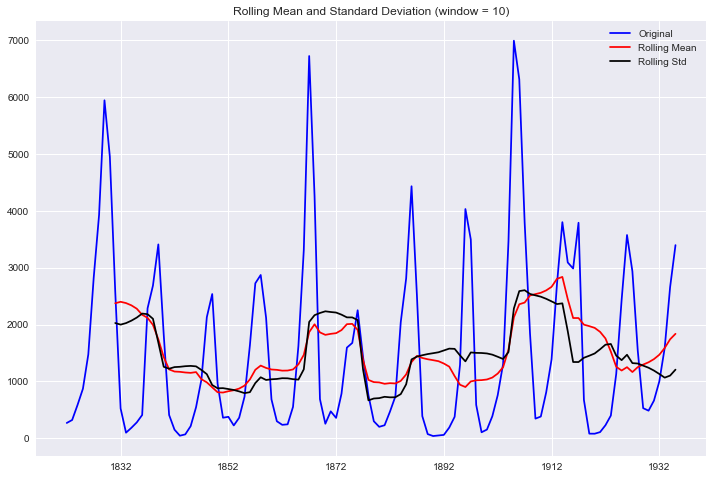

In [14]:
plot_movingavg(Lynx, 10)

In [15]:
#Exponentially Weighted Mean
#Only works for Pandas series or Pandas df object
def plot_ewma(timeseries, alpha):
    rol_mean = timeseries.ewm(alpha).mean()
    rol_std = timeseries.ewm(alpha).std()
    
    fig = plt.figure(figsize = (12, 8))
    og = plt.plot(timeseries, color = "blue", label = "Original")
    mean = plt.plot(rol_mean, color = "red", label = "Weighted Mean")
    std = plt.plot(rol_std, color = "black", label = "Weighted Std")
    plt.legend(loc = "best")
    plt.title("Exponentially Weighted Moving Average (alpha = "+str(alpha)+")")
    plt.show()

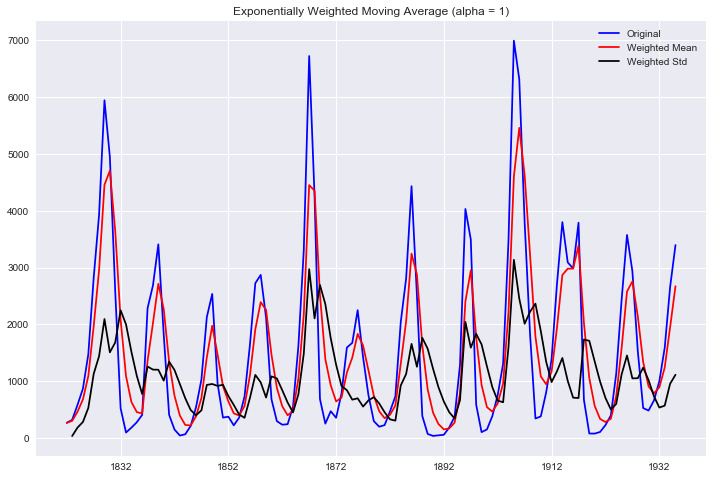

In [16]:
plot_ewma(Lynx, 1)

Set upt the ARIMA model. Since the data is stationary d =0. Similarly, p and q are determined based on pacf and acf plots respectively

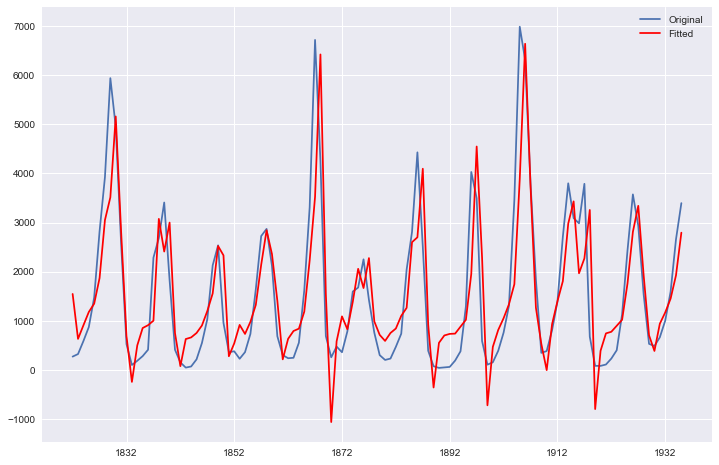

In [17]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(Lynx, order=(2, 0, 0))  
results_AR = model.fit()
plt.figure(figsize=(12,8))
plt.plot(Lynx, label = 'Original')
plt.plot(results_AR.fittedvalues, color='red', label = 'Fitted')
plt.legend(loc='best')
plt.show()

In [18]:
#Check the model parameters
results_AR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  114
Model:                     ARMA(2, 0)   Log Likelihood                -935.016
Method:                       css-mle   S.D. of innovations            876.447
Date:                Thu, 07 Mar 2019   AIC                           1878.032
Time:                        20:36:30   BIC                           1888.977
Sample:                    12-31-1821   HQIC                          1882.474
                         - 12-31-1934                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1545.3385    181.671      8.506      0.000    1189.269    1901.408
ar.L1.y        1.1474      0.074     15.459      0.000       1.002       1.293
ar.L2.y       -0.5997      0.074     -8.110      0.000      -0.745      -0.455
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9566           -0.8673j            1.2913           -0.1172
AR.2            0.9566           +0.8673j            1.2913            0.1172
-----------------------------------------------------------------------------
"""

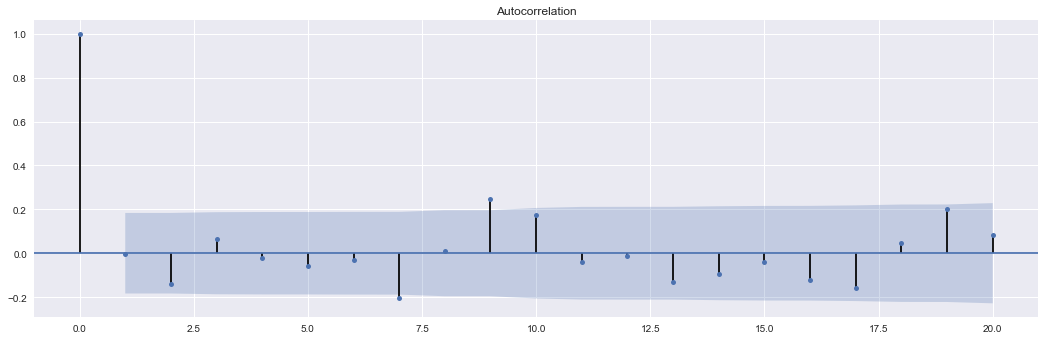

In [19]:
#Plot acf of residuals to see if autocorrelation is present
# The ACF Plot
%matplotlib inline
fig = plt.figure(figsize=(18,12))
ax1 = fig.add_subplot(211)
fig = tsaplt.plot_acf(results_AR.resid, lags=20, ax=ax1)

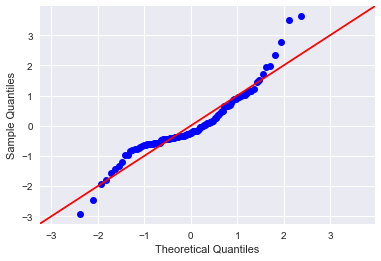

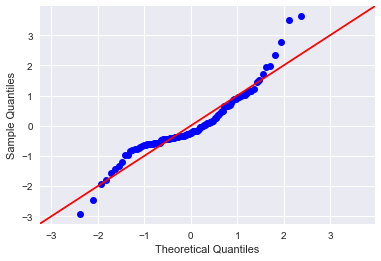

In [20]:
#Check the distribution of time series
from statsmodels.graphics.gofplots import ProbPlot
prob = ProbPlot(results_AR.resid, fit = 'TRUE')
prob.qqplot(line = '45')

The diagnostics plot is far from normal so we need to improve the model

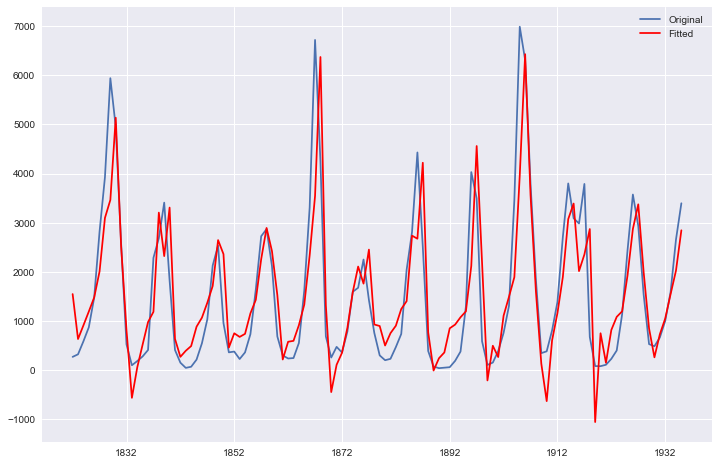

In [21]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(Lynx, order=(4, 0, 0))  
results_AR = model.fit()
plt.figure(figsize=(12,8))
plt.plot(Lynx, label = 'Original')
plt.plot(results_AR.fittedvalues, color='red', label = 'Fitted')
plt.legend(loc='best')
plt.show()

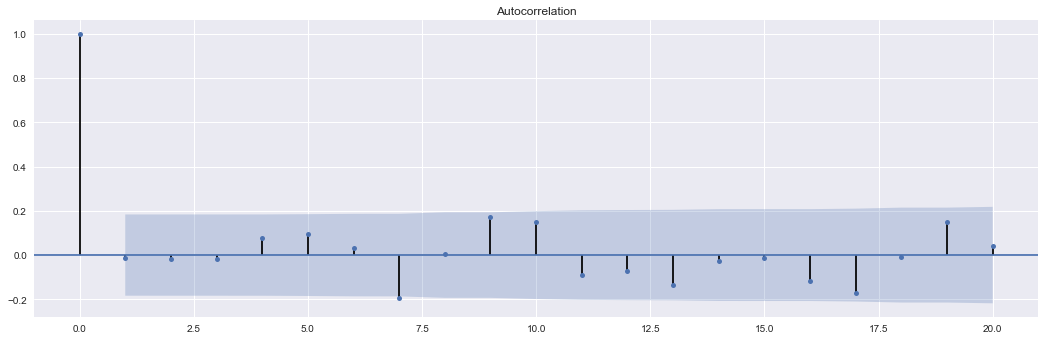

In [22]:
%matplotlib inline
fig = plt.figure(figsize=(18,12))
ax1 = fig.add_subplot(211)
fig = tsaplt.plot_acf(results_AR.resid, lags=20, ax=ax1)

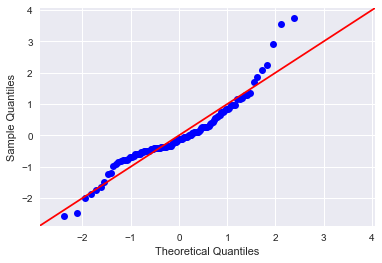

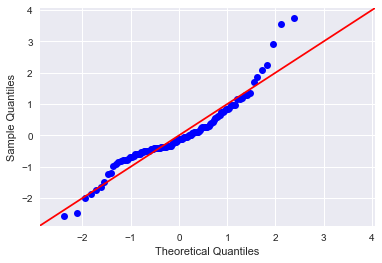

In [23]:
#Check the distribution of time series
from statsmodels.graphics.gofplots import ProbPlot
prob = ProbPlot(results_AR.resid, fit = 'TRUE')
prob.qqplot(line = '45')

Let's go with ARIMA (4,0,0) and make some forecast.

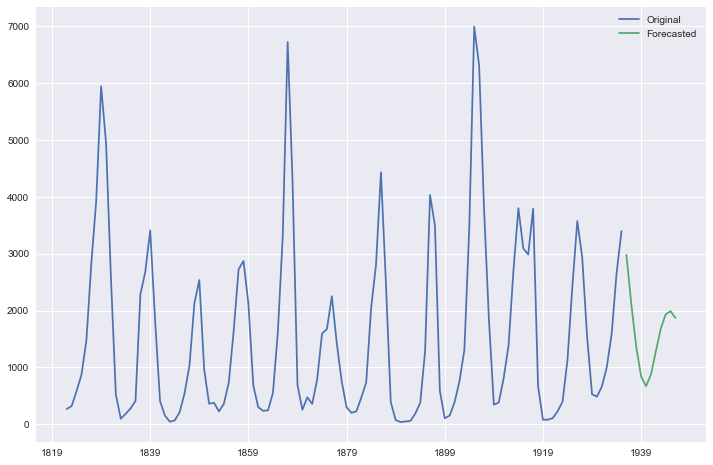

In [24]:
Fcast = results_AR.predict(start='31/12/1935', end='31/12/1945')
fig = plt.figure(figsize = (12, 8))
fig = plt.plot(Lynx, label = 'Original')
fig = plt.plot(Fcast, label = 'Forecasted')
plt.legend (loc ='best')
plt.show()